# Capstone Project: Evaluating Food Restaurant Feasibility in London, United Kingdom using k-Means Clustering

## Table of Contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

Suppose a client wants to expand his Jollybuzz food corporation to Europe. He wanted to build his first store in London, United Kingdom. However, he has little knowledge on areas and neighbourhood in the city. He also wants to know where are his competitors are located and where are the areas with least competition.

In addition, we will evaluate which value of k has the highest model accuracy in identifying clusters of neighbourhoods in London. After determining the target neighborhood cluster, we will profile the cluster based on demography and predict two-year business survival rate in the cluster.

## Data <a name="Data"></a>

We will need to get information on:
* List of Neighbourhood in London, United Kingdom
* Post codes and location of the neighbourhoods
* Venues in the neighbourhood
* London Borough Profile

There will be four sources of data:

1. List of Neighbourhood(Areas) in London - https://en.wikipedia.org/wiki/List_of_areas_of_London </li>
    This contains Location which will be the neighborhood, area which is the borough.
2. Post codes and Location data - https://www.doogal.co.uk/AdministrativeAreas.php </li>
    This contains the borough list with latitude and longitude values.
3. Venues in the neighbourhood - Foursquare API </li>
    To be extracted from Foursquare API
4. London Borough profiles - https://data.london.gov.uk/dataset/london-borough-profiles#:~:text=The%20London%20Borough%20Profiles%20help,borough%2C%20alongside%20relevant%20comparator%20areas. </li>
    Compute for Average two-year business survival rate in London and create new variable where value is equal to 1 if two-year business survival rate is above average and 0 otherwise. </li>
   </li> Use this as dependent variable and run using decision tree and logistic regression to identify significant factors affecting in the target cluster to their business survival.
 

### Importing Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import re

print('Libraries imported.')

Libraries imported.


### Webscraping List of Neighbourhoods in London

In [2]:
url  = 'https://en.wikipedia.org/wiki/List_of_areas_of_London'
df_list = pd.read_html(url)

# get 1st array which contains list of the neighbourhood
df_list[1]

Location  \
0                                        Abbey Wood   
1                                             Acton   
2                                         Addington   
3                                        Addiscombe   
4                                       Albany Park   
5                                  Aldborough Hatch   
6                                           Aldgate   
7                                           Aldwych   
8                                          Alperton   
9                                           Anerley   
10                                            Angel   
11                                        Aperfield   
12                                          Archway   
13                                   Ardleigh Green   
14                                           Arkley   
15                                      Arnos Grove   
16                                           Balham   
17                                         Bankside   
18                                         Barbican   
19                                          Barking   
20                                      Barkingside   
21                                       Barnehurst   
22                                           Barnes   
23                                      Barnes Cray   
24                                      Barnet Gate   
25       Barnet (also Chipping Barnet, High Barnet)   
26                                        Barnsbury   
27                                        Battersea   
28                                        Bayswater   
29                                        Beckenham   
30                                          Beckton   
31                                        Becontree   
32                                  Becontree Heath   
33                                       Beddington   
34                                     Bedford Park   
35                                        Belgravia   
36                                       Bellingham   
37                                          Belmont   
38                                          Belmont   
39                                     Belsize Park   
40                                        Belvedere   
41                                       Bermondsey   
42                                       Berrylands   
43                                    Bethnal Green   
44         Bexley (also Old Bexley, Bexley Village)   
45               Bexleyheath (also Bexley New Town)   
46                                          Bickley   
47                                      Biggin Hill   
48                                         Blackfen   
49                                      Blackfriars   
50                                       Blackheath   
51                        Blackheath Royal Standard   
52                                        Blackwall   
53                                          Blendon   
54                                       Bloomsbury   
55                                       Botany Bay   
56                                     Bounds Green   
57                                              Bow   
58                                       Bowes Park   
59                                        Brentford   
60                                      Brent Cross   
61                                       Brent Park   
62                                        Brimsdown   
63                                          Brixton   
64                                         Brockley   
65                                          Bromley   
66                    Bromley (also Bromley-by-Bow)   
67                                   Bromley Common   
68                                         Brompton   
69                                      Brondesbury   
70                                   Brunswick Park   
71                                      Bulls Cross   
72                          

In [3]:
colnames = ['Neighborhood', 'Borough', 'Post_town','Postcode', 'Dial code']
ldn = pd.DataFrame(df_list[1])
ldn.drop(columns =["OS grid ref"], axis = 1, inplace = True)
ldn.columns=colnames
ldn.drop(columns =["Dial code"], axis = 1, inplace = True)

ldn.head()


Neighborhood                            Borough       Post_town   Postcode
0   Abbey Wood              Bexley, Greenwich [7]          LONDON        SE2
1        Acton  Ealing, Hammersmith and Fulham[8]          LONDON     W3, W4
2    Addington                         Croydon[8]         CROYDON        CR0
3   Addiscombe                         Croydon[8]         CROYDON        CR0
4  Albany Park                             Bexley  BEXLEY, SIDCUP  DA5, DA14

In [4]:
#remove subscripts in Borough column
ldn['Borough']=ldn.Borough.str.replace('[^a-zA-Z, ]', "")
ldn.head()

Neighborhood                         Borough       Post_town   Postcode
0   Abbey Wood              Bexley, Greenwich           LONDON        SE2
1        Acton  Ealing, Hammersmith and Fulham          LONDON     W3, W4
2    Addington                         Croydon         CROYDON        CR0
3   Addiscombe                         Croydon         CROYDON        CR0
4  Albany Park                          Bexley  BEXLEY, SIDCUP  DA5, DA14

In [5]:
#split Boroughs and expand so that, one borough = one line
ldn['Borough1'] = ldn['Borough'].str.split(',',expand = True).get(0)
ldn['Borough2'] = ldn['Borough'].str.split(',',expand = True).get(1)
ldn.head()

Neighborhood                         Borough       Post_town   Postcode  \
0   Abbey Wood              Bexley, Greenwich           LONDON        SE2   
1        Acton  Ealing, Hammersmith and Fulham          LONDON     W3, W4   
2    Addington                         Croydon         CROYDON        CR0   
3   Addiscombe                         Croydon         CROYDON        CR0   
4  Albany Park                          Bexley  BEXLEY, SIDCUP  DA5, DA14   

  Borough1                 Borough2  
0   Bexley               Greenwich   
1   Ealing   Hammersmith and Fulham  
2  Croydon                     None  
3  Croydon                     None  
4   Bexley                     None

In [6]:
ldn1 = ldn[['Neighborhood', 'Borough1']]
ldn2 = ldn[['Neighborhood', 'Borough2']]
ldn1.columns = ['Neighborhood', 'Borough']
ldn2.columns = ['Neighborhood', 'Borough']
ldnf = ldn1.append( ldn2)
ldnf = ldnf[ldnf['Borough'].notnull()]
ldnf.sort_values(by = ['Borough'], inplace = True)
ldnf

Neighborhood  \
85                                   Chadwell Heath   
121                                     Cricklewood   
379                                      Queensbury   
479                                    Upper Ruxley   
454  Sydenham (also Lower Sydenham, Upper Sydenham)   
392                                          Ruxley   
470                                    Tufnell Park   
268                                         Kilburn   
358                                      Park Royal   
99                                         Chiswick   
448                                         Sudbury   
104                                     Cockfosters   
459                                      Thamesmead   
168                                      Falconwood   
0                                        Abbey Wood   
1                                             Acton   
264                                          Kenton   
173                                   Finsbury Park   
529                                  Worcester Park   
249                                       Horn Park   
260                                      Kennington   
455                                   Sydenham Hill   
524                                  Woodford Green   
409                                     Snaresbrook   
102                                         Clapham   
457                                          Temple   
19                                          Barking   
391                                      Rush Green   
131                                        Dagenham   
32                                  Becontree Heath   
31                                        Becontree   
83                                     Castle Green   
119                                      Creekmouth   
300                                      Marks Gate   
234                                          Hendon   
211                         Hampstead Garden Suburb   
253                                        The Hyde   
207                                        The Hale   
193                                    Grahame Park   
60                                      Brent Cross   
190                                   Golders Green   
181                                   Friern Barnet   
148                                   East Finchley   
70                                   Brunswick Park   
72                                        Burnt Oak   
73                                   Burroughs, The   
154                                         Edgware   
145                                     East Barnet   
121                                     Cricklewood   
108                                    Colney Hatch   
105                                       Colindale   
104                                     Cockfosters   
171                                        Finchley   
308                                       Mill Hill   
353                                          Osidge   
322                                      New Barnet   
14                                           Arkley   
24                                      Barnet Gate   
25       Barnet (also Chipping Barnet, High Barnet)   
527                                   Woodside Park   
514                                       Whetstone   
508                                     West Hendon   
312                                   Monken Hadley   
458                                  Temple Fortune   
101                                      Church End   
468                                      Totteridge   
94                                      Childs Hill   
326                                   New Southgate   
335                                  North Finchley   
347                                   Oakleigh Park   
292                                       Longlands   
282                                  Lessness Heath   
109                     

## Webscraping location data

In [7]:
url  = 'https://www.doogal.co.uk/AdministrativeAreas.php'
df_list2 = pd.read_html(url)
df_list2[0]

Administrative area                    County  Latitude  \
0                           Aberdeen City                       NaN   57.1495   
1                           Aberdeenshire                       NaN   57.3539   
2                                    Adur               West Sussex   50.8332   
3                               Allerdale                   Cumbria   54.7132   
4                            Amber Valley                Derbyshire   53.0377   
5                                   Angus                       NaN   56.6195   
6                 Antrim and Newtownabbey                       NaN   54.6982   
7                     Ards and North Down                       NaN   54.6072   
8                         Argyll and Bute                       NaN   56.0324   
9    Armagh City, Banbridge and Craigavon                       NaN   54.3849   
10                                   Arun               West Sussex   50.8087   
11                               Ashfield           Nottinghamshire   53.0875   
12                                Ashford                      Kent   51.1354   
13                                Babergh                   Suffolk   52.0389   
14                   Barking and Dagenham            Greater London   51.5465   
15                                 Barnet            Greater London   51.6055   
16                               Barnsley           South Yorkshire   53.5463   
17                      Barrow-in-Furness                   Cumbria   54.1263   
18                               Basildon                     Essex   51.5901   
19                  Basingstoke and Deane                 Hampshire   51.2870   
20                              Bassetlaw           Nottinghamshire   53.3319   
21           Bath and North East Somerset                  Somerset   51.3641   
22                                Bedford              Bedfordshire   52.1446   
23                                Belfast                       NaN   54.5934   
24                                 Bexley            Greater London   51.4592   
25                             Birmingham             West Midlands   52.4809   
26                                  Blaby            Leicestershire   52.5883   
27                  Blackburn with Darwen                Lancashire   53.7292   
28                              Blackpool                Lancashire   53.8176   
29                          Blaenau Gwent                       NaN   51.7676   
30                               Bolsover                Derbyshire   53.2072   
31                                 Bolton        Greater Manchester   53.5774   
32                                 Boston              Lincolnshire   52.9702   
33    Bournemouth, Christchurch and Poole                    Dorset   50.7358   
34                       Bracknell Forest                 Berkshire   51.4013   
35                               Bradford            West Yorkshire   53.8214   
36                              Braintree                     Essex   51.8886   
37                              Breckland                   Norfolk   52.5809   
38                                  Brent            Greater London   51.5518   
39                              Brentwood                     Essex   51.6309   
40                               Bridgend                       NaN   51.5317   
41                      Brighton and Hove               East Sussex   50.8322   
42                       Bristol, City of                   Bristol   51.4606   
43                              Broadland                   Norfolk   52.6740   
44                                Bromley            Greater London   51.3918   
45                             Bromsgrove            Worcestershire   52.3557   
46                             Broxbourne             Hertfordshire   51.7241   
47                               Broxtowe           Nottinghamshire   52.9548   
48                        Buckinghamshire           B

Convert to webscraped data into pandas data frame.

In [8]:
#convert to data frame
ll = pd.DataFrame(df_list2[0])
ll = ll.filter(items = ['Administrative area',  'Latitude', 'Longitude'])
ll.columns = ['Borough', 'Latitude', 'Longitude']
ll.head()

Borough  Latitude  Longitude
0  Aberdeen City   57.1495  -2.132940
1  Aberdeenshire   57.3539  -2.322440
2           Adur   50.8332  -0.284415
3      Allerdale   54.7132  -3.361480
4   Amber Valley   53.0377  -1.424310

Merge Location data and Neighborhood data. 

In [9]:
##combine location data and neighborhood data
ldnf_ll = pd.merge(ldnf, ll, on = "Borough")
ldnf_ll

Neighborhood                 Borough  \
0                                           Barking    Barking and Dagenham   
1                                        Rush Green    Barking and Dagenham   
2                                          Dagenham    Barking and Dagenham   
3                                   Becontree Heath    Barking and Dagenham   
4                                         Becontree    Barking and Dagenham   
5                                      Castle Green    Barking and Dagenham   
6                                        Creekmouth    Barking and Dagenham   
7                                        Marks Gate    Barking and Dagenham   
8                                            Hendon                  Barnet   
9                           Hampstead Garden Suburb                  Barnet   
10                                         The Hyde                  Barnet   
11                                         The Hale                  Barnet   
12                                     Grahame Park                  Barnet   
13                                      Brent Cross                  Barnet   
14                                    Golders Green                  Barnet   
15                                    Friern Barnet                  Barnet   
16                                    East Finchley                  Barnet   
17                                   Brunswick Park                  Barnet   
18                                        Burnt Oak                  Barnet   
19                                   Burroughs, The                  Barnet   
20                                          Edgware                  Barnet   
21                                      East Barnet                  Barnet   
22                                      Cricklewood                  Barnet   
23                                     Colney Hatch                  Barnet   
24                                        Colindale                  Barnet   
25                                      Cockfosters                  Barnet   
26                                         Finchley                  Barnet   
27                                        Mill Hill                  Barnet   
28                                           Osidge                  Barnet   
29                                       New Barnet                  Barnet   
30                                           Arkley                  Barnet   
31                                      Barnet Gate                  Barnet   
32       Barnet (also Chipping Barnet, High Barnet)                  Barnet   
33                                    Woodside Park                  Barnet   
34                                        Whetstone                  Barnet   
35                                      West Hendon                  Barnet   
36                                    Monken Hadley                  Barnet   
37                                   Temple Fortune                  Barnet   
38                                       Church End                  Barnet   
39                                       Totteridge                  Barnet   
40                                      Childs Hill                  Barnet   
41                                    New Southgate                  Barnet   
42                                   North Finchley                  Barnet   
43                                    Oakleigh Park                  Barnet   
44                                        Longlands                  Bexley   
45                                   Lessness Heath                  Bexley   
46                                          Colyers                  Bexley   
47                                         Crayford                  Bexley   
48                                         Lamorbey                  Bexley   
49                                       North Cray                  Bexley   
50        

## Creating a Map of London, United Kingdom superimposed on top

In [10]:
address = "London"

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 51.5073219, -0.1276474.


In [14]:
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighborhood in zip(ldnf_ll['Latitude'], ldnf_ll['Longitude'], ldnf_ll['Borough'], ldnf_ll['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)
map_london

## Foursquare credentials

In [15]:
CLIENT_ID = 'RHJPVBEARK2NL5NCWS4HPHPDXAEMZTIRHGKGOREX1DD3PA2U' # your Foursquare ID
CLIENT_SECRET = 'W3YBXTKR2ZNEQ1YNOJAI2AAZH3RFVJNCPEU3F1LDI52R1EIH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RHJPVBEARK2NL5NCWS4HPHPDXAEMZTIRHGKGOREX1DD3PA2U
CLIENT_SECRET:W3YBXTKR2ZNEQ1YNOJAI2AAZH3RFVJNCPEU3F1LDI52R1EIH


In [19]:
neighborhood_latitude = ldnf_ll.loc[0,'Latitude']
neighborhood_longitude = ldnf_ll.loc[0,'Longitude']

neighborhood_name = ldnf_ll.loc[0, 'Neighborhood']

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Barking are 51.5465, 0.124976.


In [20]:
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=RHJPVBEARK2NL5NCWS4HPHPDXAEMZTIRHGKGOREX1DD3PA2U&client_secret=W3YBXTKR2ZNEQ1YNOJAI2AAZH3RFVJNCPEU3F1LDI52R1EIH&v=20180605&ll=51.5465,0.124976&radius=500&limit=100'

In [21]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f30bc0494af785f94fbfee8'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Barking and Dagenham',
  'headerFullLocation': 'Barking and Dagenham, London',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 2,
  'suggestedBounds': {'ne': {'lat': 51.551000004500004,
    'lng': 0.13219862759327938},
   'sw': {'lat': 51.5419999955, 'lng': 0.11775337240672062}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e272db2149503e3719dec1a',
       'name': 'Parsloes Park',
       'location': {'address': 'Parsloes Ave.',
        'crossStreet': 'at  Gale St',
        'lat': 51.54502708490598,
        'lng': 0.

In [22]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [23]:
venues = results['response']['groups'][0]['items']

    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name                  categories        lat       lng
0  Parsloes Park                        Park  51.545027  0.125598
1    WellPainted  Construction & Landscaping  51.546835  0.118772

In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:
london_venues = getNearbyVenues(names=ldnf_ll['Neighborhood'],
                                   latitudes=ldnf_ll['Latitude'],
                                   longitudes=ldnf_ll['Longitude']
                                  )

Barking
Rush Green
Dagenham
Becontree Heath
Becontree
Castle Green
Creekmouth
Marks Gate
Hendon
Hampstead Garden Suburb
The Hyde
The Hale
Grahame Park
Brent Cross
Golders Green
Friern Barnet
East Finchley
Brunswick Park
Burnt Oak
Burroughs, The
Edgware
East Barnet
Cricklewood
Colney Hatch
Colindale
Cockfosters
Finchley
Mill Hill
Osidge
New Barnet
Arkley
Barnet Gate
Barnet (also Chipping Barnet, High Barnet)
Woodside Park
Whetstone
West Hendon
Monken Hadley
Temple Fortune
Church End
Totteridge
Childs Hill
New Southgate
North Finchley
Oakleigh Park
Longlands
Lessness Heath
Colyers
Crayford
Lamorbey
North Cray
North End
Crook Log
Crossness
Ruxley
Upton
East Wickham
Upper Ruxley
Erith
Thamesmead
Falconwood
Northumberland Heath
Slade Green
Foots Cray
Sidcup
West Heath
Welling
Abbey Wood
Albany Park
Barnehurst
Bexleyheath (also Bexley New Town)
Barnes Cray
Belvedere
Bexley (also Old Bexley, Bexley Village)
Blackfen
Blendon
Tokyngton
Preston
Dollis Hill
Willesden
Stonebridge
Sudbury
Kilburn
K

In [27]:
print(london_venues.shape)
london_venues.head()

(10617, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude          Venue  \
0      Barking                51.5465                0.124976  Parsloes Park   
1      Barking                51.5465                0.124976    WellPainted   
2   Rush Green                51.5465                0.124976  Parsloes Park   
3   Rush Green                51.5465                0.124976    WellPainted   
4     Dagenham                51.5465                0.124976  Parsloes Park   

   Venue Latitude  Venue Longitude              Venue Category  
0       51.545027         0.125598                        Park  
1       51.546835         0.118772  Construction & Landscaping  
2       51.545027         0.125598                        Park  
3       51.546835         0.118772  Construction & Landscaping  
4       51.545027         0.125598                        Park

Now, let's check enue counts per neighborhood.

In [28]:
london_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                            
Abbey Wood                                                         14   
Acton                                                               3   
Addington                                                          31   
Addiscombe                                                         31   
Albany Park                                                        14   
Aldborough Hatch                                                   17   
Aldwych                                                           100   
Alperton                                                            7   
Anerley                                                             3   
Angel                                                              57   
Aperfield                                                           3   
Archway                                                            57   
Ardleigh Green                                                      3   
Arkley                                                              5   
Arnos Grove                                                         4   
Balham                                                             10   
Bankside                                                           11   
Barking                                                             2   
Barkingside                                                        17   
Barnehurst                                                         14   
Barnes                                                             14   
Barnes Cray                                                        14   
Barnet (also Chipping Barnet, High Barnet)                          5   
Barnet Gate                                                         5   
Barnsbury                                                          57   
Battersea                                                          10   
Bayswater                                                         100   
Beckenham                                                           3   
Beckton                                                             6   
Becontree                                                           2   
Becontree Heath                                                     2   
Beddington                                                          4   
Bedford Park                                                        3   
Belgravia                                                         100   
Bellingham                                                          4   
Belmont                                                            10   
Belsize Park                                                       80   
Belvedere                                                          14   
Bermondsey                                                         11   
Berrylands                                                          3   
Bethnal Green                                                      13   
Bexley (also Old Bexley, Bexley Village)                           14   
Bexleyheath (also Bexley New Town)                                 14   
Bickley                                                             3   
Biggin Hill                                                         3   
Blackfen                                                           14   
Blackheath                                                          4   
Blackheath Royal Standard                                           6   
Blackwall                                                          13   
Blendon                                                            14   
Bloomsbury                                                         80   
Botany Bay                                                          4   
Bounds Green                                                       41   
Bow                              

In [30]:
print('There are {} uniques categories.'.format(len(london_venues['Venue Category'].unique())))

There are 170 uniques categories.


Analyzing Neighborhood and Venues around it. 

In [31]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Neighborhood'] = london_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

london_onehot.head()

Neighborhood  Afghan Restaurant  African Restaurant  American Restaurant  \
0      Barking                  0                   0                    0   
1      Barking                  0                   0                    0   
2   Rush Green                  0                   0                    0   
3   Rush Green                  0                   0                    0   
4     Dagenham                  0                   0                    0   

   Argentinian Restaurant  Art Gallery  Art Museum  Asian Restaurant  \
0                       0            0           0                 0   
1                       0            0           0                 0   
2                       0            0           0                 0   
3                       0            0           0                 0   
4                       0            0           0                 0   

   Athletics & Sports  BBQ Joint  Bakery  Bar  Beer Bar  Beer Garden  Bistro  \
0                   0          0       0    0         0            0       0   
1                   0          0       0    0         0            0       0   
2                   0          0       0    0         0            0       0   
3                   0          0       0    0         0            0       0   
4                   0          0       0    0         0            0       0   

   Boat or Ferry  Bookstore  Boutique  Bowling Alley  Breakfast Spot  Brewery  \
0              0          0         0              0               0        0   
1              0          0         0              0               0        0   
2              0          0         0              0               0        0   
3              0          0         0              0               0        0   
4              0          0         0              0               0        0   

   Building  Bulgarian Restaurant  Burger Joint  Bus Stop  Café  Camera Store  \
0         0                     0             0         0     0             0   
1         0                     0             0         0     0             0   
2         0                     0             0         0     0             0   
3         0                     0             0         0     0             0   
4         0                     0             0         0     0             0   

   Cantonese Restaurant  Caribbean Restaurant  Chinese Restaurant  \
0                     0                     0                   0   
1                     0                     0                   0   
2                     0                     0                   0   
3                     0                     0                   0   
4                     0                     0                   0   

   Chocolate Shop  Clothing Store  Cocktail Bar  Coffee Shop  Concert Hall  \
0               0               0             0            0             0   
1               0               0             0            0             0   
2               0               0             0            0             0   
3               0               0             0            0             0   
4               0               0             0            0             0   

   Construction & Landscaping  Convenience Store  Cosmetics Shop  \
0                           0                  0               0   
1                           1                  0               0   
2                           0                  0               0   
3                           1                  0               0   
4                           0                  0               0   

   Cuban Restaurant  Cupcake Shop  Dance Studio  Deli / Bodega  \
0                 0             0             0              0   
1                 0             0             0              0   
2                 0             0             0              0   
3                 0             0             0              0   
4                 0   

In [32]:
london_grouped = london_onehot.groupby('Neighborhood').mean().reset_index()
london_grouped

Neighborhood  Afghan Restaurant  \
0                                        Abbey Wood           0.000000   
1                                             Acton           0.000000   
2                                         Addington           0.000000   
3                                        Addiscombe           0.000000   
4                                       Albany Park           0.000000   
5                                  Aldborough Hatch           0.000000   
6                                           Aldwych           0.000000   
7                                          Alperton           0.000000   
8                                           Anerley           0.000000   
9                                             Angel           0.000000   
10                                        Aperfield           0.000000   
11                                          Archway           0.000000   
12                                   Ardleigh Green           0.000000   
13                                           Arkley           0.000000   
14                                      Arnos Grove           0.000000   
15                                           Balham           0.000000   
16                                         Bankside           0.000000   
17                                          Barking           0.000000   
18                                      Barkingside           0.000000   
19                                       Barnehurst           0.000000   
20                                           Barnes           0.000000   
21                                      Barnes Cray           0.000000   
22       Barnet (also Chipping Barnet, High Barnet)           0.000000   
23                                      Barnet Gate           0.000000   
24                                        Barnsbury           0.000000   
25                                        Battersea           0.000000   
26                                        Bayswater           0.000000   
27                                        Beckenham           0.000000   
28                                          Beckton           0.000000   
29                                        Becontree           0.000000   
30                                  Becontree Heath           0.000000   
31                                       Beddington           0.000000   
32                                     Bedford Park           0.000000   
33                                        Belgravia           0.000000   
34                                       Bellingham           0.000000   
35                                          Belmont           0.100000   
36                                     Belsize Park           0.000000   
37                                        Belvedere           0.000000   
38                                       Bermondsey           0.000000   
39                                       Berrylands           0.000000   
40                                    Bethnal Green           0.000000   
41         Bexley (also Old Bexley, Bexley Village)           0.000000   
42               Bexleyheath (also Bexley New Town)           0.000000   
43                                          Bickley           0.000000   
44                                      Biggin Hill           0.000000   
45                                         Blackfen           0.000000   
46                                       Blackheath           0.000000   
47                        Blackheath Royal Standard           0.000000   
48                                        Blackwall           0.000000   
49                                          Blendon           0.000000   
50                                       Bloomsbury           0.000000   
51                                       Botany Bay           0.000000   
52                                     Bounds Green           0.000000   
53                                         

In [33]:
num_top_venues = 5

for hood in london_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Abbey Wood----
                 venue  freq
0                  Pub  0.14
1          Supermarket  0.14
2   Italian Restaurant  0.07
3        Bowling Alley  0.07
4  American Restaurant  0.07


----Acton----
           venue  freq
0  Train Station  0.33
1      Gastropub  0.33
2           Park  0.33
3      Nightclub  0.00
4   Optical Shop  0.00


----Addington----
                      venue  freq
0                       Pub  0.16
1        Italian Restaurant  0.10
2  Mediterranean Restaurant  0.10
3         Indian Restaurant  0.06
4                    Museum  0.03


----Addiscombe----
                      venue  freq
0                       Pub  0.16
1        Italian Restaurant  0.10
2  Mediterranean Restaurant  0.10
3         Indian Restaurant  0.06
4                    Museum  0.03


----Albany Park----
                 venue  freq
0                  Pub  0.14
1          Supermarket  0.14
2   Italian Restaurant  0.07
3        Bowling Alley  0.07
4  American Restaurant  0.07


----Al

In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [37]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = london_grouped['Neighborhood']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0   Abbey Wood                   Pub           Supermarket   
1        Acton             Gastropub                  Park   
2    Addington                   Pub    Italian Restaurant   
3   Addiscombe                   Pub    Italian Restaurant   
4  Albany Park                   Pub           Supermarket   

      3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                       Bar     Recreation Center           Pizza Place   
1             Train Station           Yoga Studio  Fast Food Restaurant   
2  Mediterranean Restaurant     Indian Restaurant            Restaurant   
3  Mediterranean Restaurant     Indian Restaurant            Restaurant   
4                       Bar     Recreation Center           Pizza Place   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0  Fast Food Restaurant    Chinese Restaurant    Mexican Restaurant   
1   Fried Chicken Joint     French Restaurant            Food Truck   
2                   Bar      Sushi Restaurant          Concert Hall   
3                   Bar      Sushi Restaurant          Concert Hall   
4  Fast Food Restaurant    Chinese Restaurant    Mexican Restaurant   

  9th Most Common Venue 10th Most Common Venue  
0         Bowling Alley           Burger Joint  
1            Food Court      Fish & Chips Shop  
2    Seafood Restaurant   Fast Food Restaurant  
3    Seafood Restaurant   Fast Food Restaurant  
4         Bowling Alley           Burger Joint

In [39]:
london_grouped.head()

Neighborhood  Afghan Restaurant  African Restaurant  American Restaurant  \
0   Abbey Wood                0.0                 0.0             0.071429   
1        Acton                0.0                 0.0             0.000000   
2    Addington                0.0                 0.0             0.000000   
3   Addiscombe                0.0                 0.0             0.000000   
4  Albany Park                0.0                 0.0             0.071429   

   Argentinian Restaurant  Art Gallery  Art Museum  Asian Restaurant  \
0                     0.0          0.0         0.0               0.0   
1                     0.0          0.0         0.0               0.0   
2                     0.0          0.0         0.0               0.0   
3                     0.0          0.0         0.0               0.0   
4                     0.0          0.0         0.0               0.0   

   Athletics & Sports  BBQ Joint  Bakery       Bar  Beer Bar  Beer Garden  \
0                 0.0        0.0     0.0  0.071429       0.0          0.0   
1                 0.0        0.0     0.0  0.000000       0.0          0.0   
2                 0.0        0.0     0.0  0.032258       0.0          0.0   
3                 0.0        0.0     0.0  0.032258       0.0          0.0   
4                 0.0        0.0     0.0  0.071429       0.0          0.0   

     Bistro  Boat or Ferry  Bookstore  Boutique  Bowling Alley  \
0  0.000000            0.0        0.0       0.0       0.071429   
1  0.000000            0.0        0.0       0.0       0.000000   
2  0.032258            0.0        0.0       0.0       0.000000   
3  0.032258            0.0        0.0       0.0       0.000000   
4  0.000000            0.0        0.0       0.0       0.071429   

   Breakfast Spot  Brewery  Building  Bulgarian Restaurant  Burger Joint  \
0             0.0      0.0       0.0                   0.0      0.071429   
1             0.0      0.0       0.0                   0.0      0.000000   
2             0.0      0.0       0.0                   0.0      0.000000   
3             0.0      0.0       0.0                   0.0      0.000000   
4             0.0      0.0       0.0                   0.0      0.071429   

   Bus Stop  Café  Camera Store  Cantonese Restaurant  Caribbean Restaurant  \
0       0.0   0.0           0.0                   0.0                   0.0   
1       0.0   0.0           0.0                   0.0                   0.0   
2       0.0   0.0           0.0                   0.0                   0.0   
3       0.0   0.0           0.0                   0.0                   0.0   
4       0.0   0.0           0.0                   0.0                   0.0   

   Chinese Restaurant  Chocolate Shop  Clothing Store  Cocktail Bar  \
0            0.071429             0.0             0.0           0.0   
1            0.000000             0.0             0.0           0.0   
2            0.000000             0.0             0.0           0.0   
3            0.000000             0.0             0.0           0.0   
4            0.071429             0.0             0.0           0.0   

   Coffee Shop  Concert Hall  Construction & Landscaping  Convenience Store  \
0     0.000000      0.000000                         0.0                0.0   
1     0.000000      0.000000                         0.0                0.0   
2     0.032258      0.032258                         0.0                0.0   
3     0.032258      0.032258                         0.0                0.0   
4     0.000000      0.000000                         0.0                0.0   

   Cosmetics Shop  Cuban Restaurant  Cupcake Shop  Dance Studio  \
0             0.0               0.0           0.0           0.0   
1             0.0               0.0           0.0           0.0   
2             0.0               0.0           0.0           0.0   
3             0.0               0.0           0.0           0.0   
4             0.0               0.0           0.0           0.0   

   

Now, we will use this data to do k-Means clustering and then define neighborhood clusters which are Food districts and Industrial districts wherein we can also establish new food restaurants.

## Methodology <a name="Methodology"></a>

Now, we will identify the best k value with best model fit values through

In [61]:
k=5
london_grouped_clustering = london_grouped.drop('Neighborhood', 1)
km = KMeans(n_clusters = k, random_state = 0).fit(london_grouped_clustering)
km.labels_[0:10]

array([0, 3, 0, 0, 0, 0, 0, 0, 2, 0])

In [115]:

from sklearn.cluster import KMeans

# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax):
    sse = []
    score = []
    for k in range(1, kmax+1):
        kmeans = KMeans(n_clusters = k, random_state = 0).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = kmeans.inertia_
        sse.append(curr_sse)
    return sse

In [116]:
sse = calculate_WSS(london_grouped_clustering,10)
sse

[77.33086560710655,
 66.25034418500977,
 60.58146796919526,
 55.19627593199409,
 49.78040558182694,
 45.145792204268226,
 41.256782856796676,
 36.428960415628005,
 33.0654092407388,
 29.732075907405473]

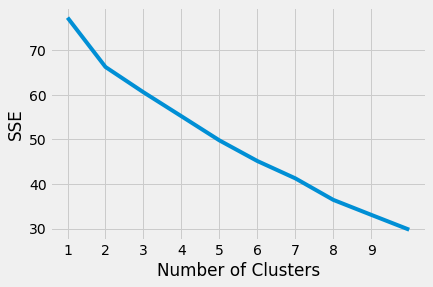

In [121]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
$ pip install kneed
from kneed import KneeLocator
kl = KneeLocator((range1,11),sse, curve = "convex", direction = "decreasing")
kl.elbow

In [ ]:

print("The best kNN model is using k=", mean.argmax()+1, "with model accuracy = ", mean.max())

#run one more time using k=7 
knn = KNeighborsClassifier(n_neighbors = 7).fit(X_train,y_train)
yhat =knn.predict(X_test)
mean = metrics.accuracy_score(y_test,yhat)
std = np.std(yhat==y_test)/np.sqrt(yhat.shape[0])